In [2]:
import torch
print("GPU available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

GPU available: True
GPU name: NVIDIA GeForce RTX 4070


In [3]:
import pandas as pd
file_path = 'Data/amazon_meta.json'  
amazon_df = pd.read_json(file_path, lines=True, compression=None)
amazon_df.shape

(633883, 19)

In [8]:
amazon_df.columns

Index(['category', 'tech1', 'description', 'fit', 'title', 'also_buy', 'tech2',
       'brand', 'feature', 'rank', 'also_view', 'main_cat', 'similar_item',
       'date', 'price', 'asin', 'imageURL', 'imageURLHighRes', 'details'],
      dtype='object')

In [4]:
df_arts = pd.read_csv('Data/Toysandchildren_ArtsandCrafts.csv', skiprows=2)
df_riding = pd.read_csv('Data/Toysandchildren_Riding_Toys.csv', skiprows=1)
df_toys = pd.read_csv('Data/Toysandchildren_Toys.csv', skiprows=1)

In [6]:
recalls_df = pd.concat([df_arts, df_riding, df_toys], ignore_index=True)
# Preview
print("Combined recall records:", len(recalls_df))
print("Columns:", recalls_df.columns.tolist())
recalls_df.head(3)

Combined recall records: 2514
Columns: ['Report No.', 'Report Date', 'Sent to Manufacturer / Importer / Private Labeler', 'Publication Date', 'Category of Submitter', 'Product Description', 'Product Category', 'Product Sub Category', 'Product Type', 'Product Code', 'Manufacturer / Importer / Private Labeler Name', 'Brand', 'Model Name or Number', 'Serial Number', 'UPC', 'Date Manufactured', 'Manufacturer Date Code', 'Retailer', 'Retailer State', 'Purchase Date', 'Purchase Date Is Estimate', 'Incident Description', 'City', 'State', 'ZIP', 'Location', '(Primary) Victim Severity', "(Primary) Victim's Sex", 'My Relation To The (Primary) Victim', "(Primary) Victim's Age (years)", 'Submitter Has Product', 'Product Was Damaged Before Incident', 'Damage Description', 'Damage Repaired', 'Product Was Modified Before Incident', 'Have You Contacted The Manufacturer', 'If Not Do You Plan To', 'Answer Explanation', 'Company Comments', 'Associated Report Numbers']


,Report No.,Report Date,Sent to Manufacturer / Importer / Private Labeler,Publication Date,Category of Submitter,Product Description,Product Category,Product Sub Category,Product Type,Product Code,...,Submitter Has Product,Product Was Damaged Before Incident,Damage Description,Damage Repaired,Product Was Modified Before Incident,Have You Contacted The Manufacturer,If Not Do You Plan To,Answer Explanation,Company Comments,Associated Report Numbers
0,20231002-D13C7-2147344911,10/2/2023,10/27/2023,11/20/2023,Consumer,Slime globe with colored spheres which resembl...,Toys & Children,Arts & Crafts,Molding Compounds (1376),1376,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TOYSMITH: Thank you for the opportunity to rev...,NaN
1,20180126-BBF18-2147393362,1/26/2018,4/13/2018,4/27/2018,Consumer,Slime kit from Nickelodeon by Cra-Z-Art,Toys & Children,Arts & Crafts,Molding Compounds (1376),1376,...,Yes,No,NaN,NaN,No,Yes,NaN,I already have explained.,We at Cra-Z-Art® are very sorry that the cons...,NaN
2,20141231-7C153-2147437145,12/31/2014,1/9/2015,1/26/2015,Consumer,Lalaloopsy Color Me Doll ( Squiggles N. Shapes...,Toys & Children,Arts & Crafts,Crayons or Chalk (5010),5010,...,NaN,NaN,NaN,NaN,NaN,No,No,NaN,The chalk markers included with this item are ...,NaN


## Calculating Similarity Scores Between Amazon and Recall Products Using a Pre-Trained Model (`intfloat/e5-large-v2`)

In [7]:
# -----------------------------------------------------------
# 0 · Imports
# -----------------------------------------------------------
from sentence_transformers import SentenceTransformer
import torch, numpy as np, pandas as pd

# -----------------------------------------------------------
# 1 · safe_cat remains the same (builds text blobs)
# -----------------------------------------------------------
def safe_cat(df: pd.DataFrame, cols: list[str]) -> pd.Series:
    parts = []
    for c in cols:
        if c in df.columns:
            col = df[c]
            if col.dtype == "object" and col.map(type).eq(list).any():
                col = col.apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))
            parts.append(col.astype(str).fillna(''))
        else:
            parts.append(pd.Series([''] * len(df), index=df.index))
    return pd.Series([' '.join(p).strip() for p in zip(*parts)], index=df.index)

amazon_text  = safe_cat(amazon_df,
                        ['brand', 'title', 'description']).tolist()
recalls_text = safe_cat(recalls_df,
                        ['Brand', 'Model Name or Number', 'Product Description']).tolist()

# -----------------------------------------------------------
# 2 · Sentence-Transformer model (fp16) on GPU
# -----------------------------------------------------------
model = SentenceTransformer("intfloat/e5-large-v2", device="cuda")
model.half()                          # make the model itself fp16

@torch.inference_mode()
def encode_stream(texts, batch=256):
    """Yield-normalised fp16 numpy embeddings, batching on GPU."""
    chunks = []
    for i in range(0, len(texts), batch):
        embs = model.encode(
            texts[i:i+batch],
            batch_size=batch,
            convert_to_tensor=True,       # GPU tensor
            normalize_embeddings=True
        ).half().cpu()                   # move to CPU, fp16
        chunks.append(embs)
        torch.cuda.empty_cache()         # release VRAM right away
    return torch.cat(chunks, dim=0).numpy()

cat_emb = encode_stream(amazon_text, 256)      # CPU ndarray, shape (600k,1024)
qry_emb = encode_stream(recalls_text, 64)      # ~3k rows, still tiny

# -----------------------------------------------------------
# 3 · Similarity search on GPU (all fits: 1.2 GB + a few MB)
# -----------------------------------------------------------
cat_gpu = torch.from_numpy(cat_emb).to('cuda')         # 600k × 1024 fp16 ≈1.2 GB
qry_gpu = torch.from_numpy(qry_emb).to('cuda')

k = 20
sims, idxs = torch.topk(qry_gpu @ cat_gpu.T, k=k, dim=1)
indices = idxs.cpu().numpy();  sims = sims.cpu().numpy()

# -----------------------------------------------------------
# 4 · Pack as DataFrame
# -----------------------------------------------------------
rows = [{"recall_idx": q, "amazon_idx": a, "rank": r+1, "similarity": float(s)}
        for q, (ii, ss) in enumerate(zip(indices, sims))
        for r, (a, s)  in enumerate(zip(ii, ss))]
matches_df = pd.DataFrame(rows)

C:\Users\Betul\anaconda3\envs\pytorch_env\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [8]:
matches_df.to_csv("matches_df.csv", index=True)

In [20]:
matches_df.head(20)

,recall_idx,amazon_idx,rank,similarity
0,0,150388,1,0.841797
1,0,190209,2,0.837891
2,0,485220,3,0.837402
3,0,69932,4,0.836426
4,0,276102,5,0.835449
5,0,591132,6,0.833008
6,0,144243,7,0.833008
7,0,547257,8,0.833008
8,0,196781,9,0.832520
9,0,162450,10,0.831055


In [58]:
matches_df[matches_df['similarity']>0.95]

,recall_idx,amazon_idx,rank,similarity
1380,69,39429,1,0.955566
1840,92,203999,1,0.961914
3080,154,103352,1,0.952148
3081,154,596598,2,0.950684
3360,168,484612,1,0.950195
6520,326,194838,1,0.960449
10860,543,207940,1,0.972168
12900,645,454156,1,0.952637
16620,831,281716,1,0.985352
16621,831,364003,2,0.958984


In [52]:
def print_metadata(df, indices):
    
    for i in indices:
        if i >= len(df):
            print(f"⚠️ Index {i} is out of bounds.")
            continue

        meta_row = df.iloc[i]
        
        print("🔹 META")
        print(f"Brand:   {meta_row.get('brand', 'N/A')}")
        print(f"Title:   {meta_row.get('title', 'N/A')}")
        print(f"Feature: {meta_row.get('feature', 'N/A')}")
        print("-" * 80)

def print_recall_data(df, indices):
    
    for i in indices:
        if i >= len(df):
            print(f"⚠️ Index {i} is out of bounds.")
            continue

        recall_row = df.iloc[i]

        print("🔹 REPORT")
        print(f"Brand:               {recall_row.get('Brand', 'N/A')}")
        print(f"Product Description: {recall_row.get('Product Description', 'N/A')}")
        print("-" * 80)

In [60]:
recall_indices = [69]
amazon_indices = [39429]
print_recall_data(recalls_df, recall_indices)
print_metadata(amazon_df, amazon_indices)

🔹 REPORT
Brand:               KiddieLand
Product Description: Convertible Baby Rocker/Walker/Ride On ToyDescription Product DescriptionImagine, a ride-on toy that develops right along with your child. The Disney Princess 4-in-1 Ride-On adapts to your child's age. From a rocker to a ride-on, with parental handle control and without, this fun-on-the-move vehicle promises hours and hours of fun. It's all with an eye towards safety and security, and all in the company of her favorite Disney Princesses. Press the buttons for lots of light-and-sound action. Play the keyboard as the Princesses dance. When your little princess is ready for a ride-on, simply remove the rocker base and listen for the real car sounds as she turns the key and pushes the throttle. It's truly a ride through Wonderland. The Disney Princess 4-in-1 Ride-On features: Includes ride-on vehicle, rocker base, parental handle control, seatback handle bar, assembly fixtures and instructions Disney Princess vehicle turns from 

**Note:** Using a threshold of 0.84 for similarity scores does not always yield good matches. Increasing the threshold to 0.95 improves precision but may result in missing some true positive cases.

To improve the quality of matches, we first perform brand matching using fuzzy string matching.  
Next, we apply two different methods:

1. **Fuzzy Matching:** We apply fuzzy matcto match both the product title and product description.
2. **Pre-Trained Model:** We use a pre-trained model to calculate similarity scores between Amazon product titles and incident product descriptions.
.


In [68]:
from rapidfuzz import fuzz
from rapidfuzz.process import cdist

def compute_brand_similarity_matrix(recalls_df, amazon_df, scorer=fuzz.token_sort_ratio, score_cutoff=90, workers=24):
    
    UNMATCHABLE = "__MISSING__"

    brand_queries = (recalls_df['Brand'].fillna(UNMATCHABLE).astype(str).str.lower().str.strip().tolist())
    
    brand_choices = (amazon_df['brand'].fillna(UNMATCHABLE).astype(str).str.lower().str.strip().tolist())

    similarity_brand_matrix = cdist(brand_queries, brand_choices, scorer=scorer, processor=None, score_cutoff=score_cutoff, workers=workers)
    
    return similarity_brand_matrix

In [70]:
brand_matrix_s2_sc90 = compute_brand_similarity_matrix(recalls_df, amazon_df, scorer=fuzz.token_set_ratio, score_cutoff=90, workers=24)

### Using Fuzzy Matching for Titles and Product Descriptions


We first calculate similarity matrices for brand matches as well as for titles and product descriptions. Next, we generate a DataFrame with the same length as the Amazon dataset to store binary match labels and the indices of matched recall products.


In [128]:
def compute_description_similarity_matrix(recalls_df, amazon_df, scorer=fuzz.token_set_ratio, score_cutoff=80, workers=24):
    """
    Compute a description/title similarity matrix using fuzzy matching.
    Returns:
        similarity_desc_matrix: list of lists with (matched_string, score, amazon_index)
    """
    desc_queries = (recalls_df['Product Description'].fillna("").astype(str).str.lower().str.strip().tolist())
    
    title_choices = (amazon_df['title'].fillna("").astype(str).str.lower().str.strip().tolist())

    similarity_desc_matrix = cdist(desc_queries, title_choices, scorer=scorer, processor=None, score_cutoff=score_cutoff, workers=workers)

    return similarity_desc_matrix

In [130]:
brand_matrix_s2_sc90 = compute_brand_similarity_matrix(recalls_df, amazon_df, scorer=fuzz.token_set_ratio, score_cutoff=90, workers=24)
desc_matrix_s2_sc80 = compute_description_similarity_matrix(recalls_df, amazon_df,  scorer=fuzz.token_set_ratio, score_cutoff=80, workers=24)

In [131]:
from collections import defaultdict

def compute_amazon_match_df(amazon_df, recalls_df, brand_matrix, desc_matrix):
    
    # 1) map amazon_idx -> list of recall_df indices
    matches = defaultdict(list)
    recall_global_indices = list(recalls_df.index)
    n_reports = len(brand_matrix)

    # guard: if recalls_df shorter, truncate
    if len(recall_global_indices) < n_reports:
        recall_global_indices = recall_global_indices[:n_reports]

    for report_pos in range(n_reports):
        # extract the sets of matching amazon indices
        row_b = brand_matrix[report_pos]
        if isinstance(row_b, np.ndarray):
            brand_idxs = set(np.nonzero(row_b)[0])
        else:
            brand_idxs = {idx for _, _, idx in row_b}

        row_d = desc_matrix[report_pos]
        if isinstance(row_d, np.ndarray):
            desc_idxs = set(np.nonzero(row_d)[0])
        else:
            desc_idxs = {idx for _, _, idx in row_d}

        common = brand_idxs & desc_idxs
        if not common:
            continue

        recall_idx = recall_global_indices[report_pos]
        for amazon_idx in common:
            matches[amazon_idx].append(recall_idx)

    # 2) build the two columns
    matched_lists = pd.Series(
        [matches.get(i, []) for i in amazon_df.index],
        index=amazon_df.index,
        name='matched_recall_indices'
    )
    is_match = matched_lists.str.len().gt(0).astype(int)

    # 3) return as DataFrame
    return pd.DataFrame({
        'matched_recall_indices': matched_lists,
        'is_match':                is_match
    })

In [132]:
match_df_s2_sc90 =  compute_amazon_match_df(amazon_df, recalls_df, brand_matrix_s2_sc90, desc_matrix_s2_sc80)

In [133]:
from typing import Dict, List

def compare_match_columns(col_a, col_b):

    # align indices, filling missing with 0
    a, b = col_a.align(col_b, join='inner', fill_value=0)
    a_mask = a == 1
    b_mask = b == 1

    intersection   = a.index[a_mask & b_mask].tolist()
    only_a         = a.index[a_mask & ~b_mask].tolist()
    only_b         = a.index[~a_mask & b_mask].tolist()
    symmetric_diff = a.index[a_mask ^ b_mask].tolist()

    return {
        'intersection':    intersection,
        'only_a':          only_a,
        'only_b':          only_b,
        'symmetric_diff':  symmetric_diff
    }

In [140]:
def print_difference(diff_amazon_ind, match_df, amazon_df):
    for id_a in diff_amazon_ind:
        print(f"Amazon Index: {id_a}")
        print_metadata(amazon_df, [id_a])
        recall_indices = match_df.loc[id_a,['matched_recall_indices']]
        print_recall_data(recalls_df, recall_indices.iloc[0])

## Calculate the Similarity Scores With Pretrained Model

In [161]:
def label_amazon_by_brand_and_title(
        amazon_df:           pd.DataFrame,
        recalls_df:          pd.DataFrame,
        brand_sim_matrix:    np.ndarray,   # shape (n_recalls, n_amazon)
        title_score_thresh:  float = 0.80,
        *,
        amazon_title_col:    str   = "title",
        recall_desc_col:     str   = "Product Description",
        model_name:          str   = "intfloat/e5-large-v2",
        batch_size:          int   = 256,
        device:              str   = "cuda"
    ) -> pd.DataFrame:
    """
    1.  brand_sim_matrix[r, a]  > 0  ⇒  (recall r, amazon a) share a brand.
    2.  For each such pair, compute cosine( title[a], desc[r] ).
    3.  Keep pairs whose cosine ≥ title_score_thresh.
    4.  Return a copy of amazon_df with four new columns:
          • match_recall_indices   — list[int]      (kept in the same order)
          • match_recall_scores    — list[float]    (parallel to the indices)
          • num_matches            — int            (len of the list)
          • is_match               — 0/1            (num_matches > 0)
    """

    # ---------- 1 · Load transformer & embed ----------
    model = SentenceTransformer(model_name, device=device)
    model.half()

    @torch.inference_mode()
    def _embed(texts, bs=batch_size):
        parts = []
        for i in range(0, len(texts), bs):
            part = model.encode(
                texts[i:i+bs],
                batch_size=bs,
                convert_to_tensor=True,
                normalize_embeddings=True,
            ).half().cpu()
            parts.append(part)
            torch.cuda.empty_cache()
        return torch.cat(parts).numpy()

    amazon_titles = amazon_df[amazon_title_col].fillna("").astype(str).tolist()
    recall_descs  = recalls_df[recall_desc_col].fillna("").astype(str).tolist()

    amazon_emb = _embed(amazon_titles)      # (n_amz, 1024)
    recall_emb = _embed(recall_descs)       # (n_rec, 1024)

    # ---------- 2 · Brand-filtered candidate list ----------
    # brand_sim_matrix > 0  means “brand passed whatever cutoff we used”
    cand_map = {a: np.nonzero(brand_sim_matrix[:, a])[0]
                for a in range(brand_sim_matrix.shape[1])}

    # ---------- 3 · Second-stage similarity ----------
    match_indices = [[] for _ in range(len(amazon_df))]
    match_scores  = [[] for _ in range(len(amazon_df))]

    for a_idx, r_idxs in cand_map.items():
        if r_idxs.size == 0:
            continue
        vec_a = amazon_emb[a_idx]                    # 1 × 1024
        sims   = recall_emb[r_idxs] @ vec_a          # cosine (embeddings L2-norm = 1)
        keep_mask = sims >= title_score_thresh
        if keep_mask.any():
            match_indices[a_idx].extend(r_idxs[keep_mask].tolist())
            match_scores[a_idx].extend(sims[keep_mask].tolist())

    # ---------- 4 · Assemble output ----------
    out = amazon_df.copy()
    out["matched_recall_indices"] = match_indices
    out["matched_recall_scores"]  = match_scores
    out["num_matches"]          = out["matched_recall_indices"].str.len()
    out["is_match"]             = (out["num_matches"] > 0).astype(int)

    return out


In [163]:
amazon_labeled2 = label_amazon_by_brand_and_title(
    amazon_df,
    recalls_df,
    brand_sim_matrix = brand_matrix_s2_sc90,
    title_score_thresh = 0.84          
)

In [165]:
result2 = compare_match_columns(amazon_labeled2['is_match'],match_df_s2_sc90['is_match'])

print("✓ Both methods agree on:", len(result2['intersection']))
print("✗ Only method1:",      len(result2['only_a']))
print("✗ Only method2:",      len(result2['only_b']))
print("🔀 Methods disagree:",          len(result2['symmetric_diff']))

✓ Both methods agree on: 3076
✗ Only method1: 29642
✗ Only method2: 2029
🔀 Methods disagree: 31671


Both methods agree on 3,076 product matches.  
The method using the pre-trained model identified 29,642 matches that were not captured by the fuzzy matching approach.  
Conversely, the fuzzy matching method found 2,029 unique matches that were not identified by the pre-trained mode.


## Analyzing Matches Captured by Fuzzy Matching but Missed by the Pre-Trained Model

In [173]:
print_difference(result['only_b'][:10], match_df_s2_sc90, amazon_df)

Amazon Index: 1755
🔹 META
Brand:   SYMA
Title:   Syma 3 Channel S107/S107G Mini Indoor Co-Axial R/C Helicopter w/ Gyro (White Color)
Feature: []
--------------------------------------------------------------------------------
🔹 REPORT
Brand:               Syma
Product Description: R/C Helicopter 
--------------------------------------------------------------------------------
Amazon Index: 1758
🔹 META
Brand:   SYMA
Title:   SYMA S009G AH-64 Apache 3 Channel Indoor Helicopter with Gyroscope
Feature: ['S0099G AH-64 Apache 3 channel helicopter indoor']
--------------------------------------------------------------------------------
🔹 REPORT
Brand:               Syma
Product Description: R/C Helicopter 
--------------------------------------------------------------------------------
Amazon Index: 1907
🔹 META
Brand:   SYMA
Title:   SYMA 3 Channel S029 Agusta Dauphin Mini RC Helicopter ---NEW!
Feature: []
--------------------------------------------------------------------------------
🔹 REPO

Upon reviewing the matches identified by the fuzzy matching method but not captured by the pre-trained model, we found that these results are generally of good quality. 

To further refine them, we will calculate their similarity scores using the pre-trained model and discard those with low score.


In [209]:
from typing import Sequence

def get_matched_title_similarity_scores(
    amazon_df:      pd.DataFrame,
    recalls_df:     pd.DataFrame,
    match_df:       pd.DataFrame,            # MUST have 'matched_recall_indices'
    *,
    amazon_indices: Sequence[int],           # subset to score
    amazon_title_col: str = "title",
    recall_desc_col:  str = "Product Description",
    model_name:       str = "intfloat/e5-large-v2",
    device:           str = "cuda",
    batch_size:       int = 256,
) -> pd.DataFrame:

    # ------------------------------------------------------------------ #
    # 0 · Normalise & sanity-check inputs
    # ------------------------------------------------------------------ #
    amazon_indices = list(dict.fromkeys(amazon_indices))        # deduplicate
    missing = [idx for idx in amazon_indices if idx not in match_df.index]
    if missing:
        raise ValueError(f"These amazon_indices are absent from match_df: {missing}")

    # ------------------------------------------------------------------ #
    # 1 · Collect ALL recall rows referenced by those Amazon items
    # ------------------------------------------------------------------ #
    recall_used = {
        rid
        for a_idx in amazon_indices
        for rid in match_df.at[a_idx, "matched_recall_indices"]
    }
    recall_used = sorted(recall_used)

    # ------------------------------------------------------------------ #
    # 2 · Embed titles & descriptions (fp16 on GPU)
    # ------------------------------------------------------------------ #
    model = SentenceTransformer(model_name, device=device).half()

    @torch.inference_mode()
    def _embed(texts):
        chunks = []
        for i in range(0, len(texts), batch_size):
            part = model.encode(
                texts[i : i + batch_size],
                batch_size=batch_size,
                convert_to_tensor=True,
                normalize_embeddings=True,
            ).half()            # stays on the same device as the model
            chunks.append(part)
        return torch.cat(chunks)

    amazon_titles = (
        amazon_df.loc[amazon_indices, amazon_title_col]
        .fillna("")
        .astype(str)
        .tolist()
    )
    amazon_embs = _embed(amazon_titles)                     # (k, 1024)

    recall_descs = (
        recalls_df.loc[recall_used, recall_desc_col]
        .fillna("")
        .astype(str)
        .tolist()
    )
    recall_embs = _embed(recall_descs)                      # (m, 1024)
    rec_idx2emb = dict(zip(recall_used, recall_embs))

    # map Amazon index → row offset in amazon_embs
    aidx2row = {a: i for i, a in enumerate(amazon_indices)}

    # ------------------------------------------------------------------ #
    # 3 · Build per-row score lists
    # ------------------------------------------------------------------ #
    score_lists = []
    for a_idx in amazon_indices:
        a_emb = amazon_embs[aidx2row[a_idx]]
        scores = [
            float(torch.nn.functional.cosine_similarity(a_emb, rec_idx2emb[r], dim=0))
            for r in match_df.at[a_idx, "matched_recall_indices"]
        ]
        score_lists.append(scores)

    # ------------------------------------------------------------------ #
    # 4 · Attach the new column without broadcasting issues
    # ------------------------------------------------------------------ #
    out = match_df.copy()

    # 4a) start with a DISTINCT empty list for every row
    out["matched_recall_scores"] = [[] for _ in range(len(out))]

    # 4b) create a Series with proper index alignment
    score_ser = pd.Series(score_lists, index=amazon_indices, dtype=object)

    # 4c) assign only to those rows
    out.loc[score_ser.index, "matched_recall_scores"] = score_ser

    return out


In [211]:
scores_df = get_matched_title_similarity_scores(
    amazon_df,
    recalls_df,
    match_df_s2_sc90,
    model_name = "intfloat/e5-large-v2",
    amazon_title_col = "title",
    recall_desc_col = "Product Description",
    device = "cuda",
    batch_size = 256,
    amazon_indices = result2['only_b']
) 

In [233]:
all_scores = []
for ind_a in result2['only_b']:
    all_scores+= scores_df.loc[ind_a,['matched_recall_scores']].iloc[0]
    

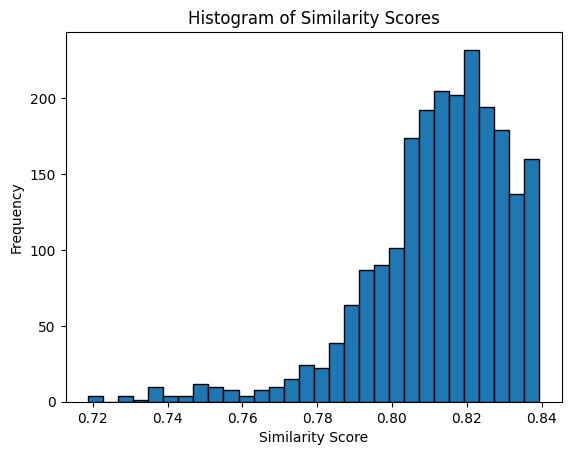

In [243]:
import matplotlib.pyplot as plt

plt.hist(all_scores, bins=30, edgecolor='black')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.title('Histogram of Similarity Scores')
plt.show()


We will drop the match if the similarity score is below 0.8.

In [395]:
def score_based_drop(amazon_indices, matched_recall_column, score_column, threshold):
    import numpy as np
    import pandas as pd

    label_col_only_b = np.zeros(len(matched_recall_column), dtype=int)
    recall_indices_only_b = pd.Series([[] for _ in range(len(matched_recall_column))])

    for ind_a in amazon_indices:
        for i, ind_r in enumerate(matched_recall_column.loc[ind_a]):
            if score_column.loc[ind_a][i] >= threshold:
                label_col_only_b[ind_a] = 1
                recall_indices_only_b.loc[ind_a].append(ind_r)

    return pd.DataFrame({
        "is_match": label_col_only_b,
        "matched_recall_indices": recall_indices_only_b
    })
    

In [397]:
only_b_df = score_based_drop(result2['only_b'], match_df_s2_sc90["matched_recall_indices"], scores_df["matched_recall_scores"], 0.8)

In [399]:
only_b_df["is_match"].value_counts()

is_match
0    632172
1      1711
Name: count, dtype: int64

1711 Amazon products are matched by fuzzy matching but missed by pre-trained model. 

## Analyzing Matches Captured by Pre-Trained Model but Missed by the Fuzzy Matching 

In [258]:
all_scores2 = []
for ind_a in result2['only_a']:
    all_scores2+= amazon_labeled2.loc[ind_a,['matched_recall_scores']].iloc[0]

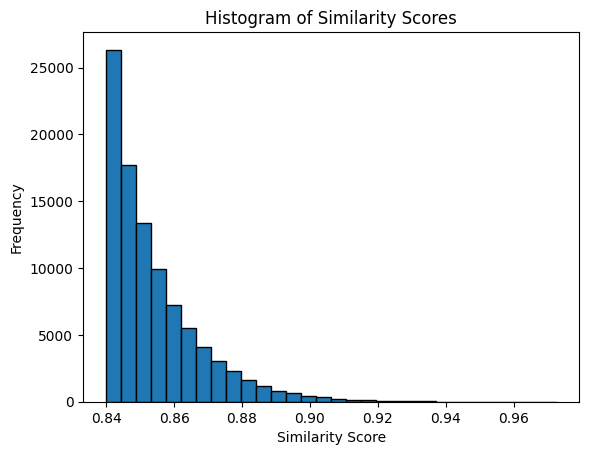

In [260]:
plt.hist(all_scores2, bins=30, edgecolor='black')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.title('Histogram of Similarity Scores')
plt.show()

Get similarity scores greater than 0.90.

In [412]:
only_a_df = score_based_drop(result2['only_a'], amazon_labeled2["matched_recall_indices"], amazon_labeled2["matched_recall_scores"], 0.9)

In [414]:
only_a_df["is_match"].value_counts()

is_match
0    632921
1       962
Name: count, dtype: int64

There are 962 Amazon products that are matched by pre-trained model, but not captured by Fuzzy match. Let's print some items:

In [423]:
amazon_ind_only_a = np.nonzero(only_a_df["is_match"].values)[0]
print_difference(amazon_ind_only_a[:10], only_a_df, amazon_df)

Amazon Index: 2049
🔹 META
Brand:   Little Tikes
Title:   Little Tikes Roadster Toddler Bed
Feature: ['Sporty roadster car styling', 'Holds crib size mattress (not included)', 'Recommended Age Range 15 months to 5 years']
--------------------------------------------------------------------------------
🔹 REPORT
Brand:               Little Tikes
Product Description: Little Tikes Deluxe 2-in-1 Cozy Roadster
--------------------------------------------------------------------------------
Amazon Index: 2094
🔹 META
Brand:   Radio Flyer
Title:   Radio Flyer Town and Country Wagon
Feature: ['N/A', 'Imported', 'Extra-large all wood body for maximum hauling capacity.', 'Removable wooden sides for easy in-and-out.', '10 durable steel wheels with real rubber tires for a quiet ride.', 'Extra-long handle folds under for easy storage.', 'FOR 1 + YEARS.Weight Capacity:150 lbs', '<span class="a-size-base a-color-secondary">\n                Extra-large all wood body for maximum hauling capacity\n       

While there are some false positives, many of the matches are of good.  
Since our goal is to capture as many true matches as possible, we will include these in our dataset


## Matches Captured by Both Methods

In [430]:
def get_label_and_recall_indices(amazon_indices, matched_recall_column):

    label_col = np.zeros(len(matched_recall_column), dtype=int)
    recall_indices = pd.Series([[] for _ in range(len(matched_recall_column))])

    for ind_a in amazon_indices:
        label_col[ind_a] = 1
        recall_indices.loc[ind_a] = matched_recall_column.loc[ind_a]

    return pd.DataFrame({
        "is_match": label_col,
        "matched_recall_indices": recall_indices
    })

In [432]:
intersection_df = get_label_and_recall_indices(result2['intersection'], match_df_s2_sc90["matched_recall_indices"])

In [436]:
amazon_ind_both = np.nonzero(intersection_df["is_match"].values)[0]
print_difference(amazon_ind_both[:10], intersection_df, amazon_df)

Amazon Index: 7
🔹 META
Brand:   UDI
Title:   UDI U806 Infrared Remote Control Helicopter W/gyro - RED
Feature: ['Includes 3.7 volt lithium battery', 'Includes USB data cable']
--------------------------------------------------------------------------------
🔹 REPORT
Brand:               UDI R/C U16
Product Description: Remote Control Helicopter
--------------------------------------------------------------------------------
Amazon Index: 1755
🔹 META
Brand:   SYMA
Title:   Syma 3 Channel S107/S107G Mini Indoor Co-Axial R/C Helicopter w/ Gyro (White Color)
Feature: []
--------------------------------------------------------------------------------
🔹 REPORT
Brand:               Syma
Product Description: R/C Helicopter 
--------------------------------------------------------------------------------
Amazon Index: 1758
🔹 META
Brand:   SYMA
Title:   SYMA S009G AH-64 Apache 3 Channel Indoor Helicopter with Gyroscope
Feature: ['S0099G AH-64 Apache 3 channel helicopter indoor']
-----------------

In [440]:
intersection_df["is_match"].value_counts()

is_match
0    630807
1      3076
Name: count, dtype: int64

## Combining Matches from All Three Methods

In [442]:
amazon_df['is_match'] = intersection_df["is_match"] + only_a_df["is_match"] + only_b_df["is_match"]

In [444]:
amazon_df['is_match'].value_counts()

is_match
0    628134
1      5749
Name: count, dtype: int64

In [446]:
amazon_df['matched_recall_indices'] = [
    a + b + c
    for a, b, c in zip(
        intersection_df["matched_recall_indices"],
        only_a_df["matched_recall_indices"],
        only_b_df["matched_recall_indices"]
    )
]

In [448]:
amazon_df.to_csv("amazon_df_output.csv", index=True)

In [449]:
amazon_df[["is_match","'matched_recall_indices"]].to_csv("match_label_recall_indices.csv", index=True)

KeyError: '["\'matched_recall_indices"] not in index'